<a href="https://colab.research.google.com/github/shreyab375/LSTM-Forecasting-Models-/blob/main/CNN%2BLSTM%2BAttention_Models_for_Time_Series_Backcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

#Step 1
import numpy as np
import joblib
import pandas as pd
import datetime
import tensorflow as tf
import os
import random
import timeit
import seaborn as sns
import datetime
import matplotlib.pyplot as plt

import tensorflow_probability as tfp
from tensorflow.keras.models import Sequential, Model
from keras.layers import Input, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, Activation, Flatten, concatenate, Permute, Multiply
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import RootMeanSquaredError

In [3]:
#Reade the data
df_sn=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/snv1_full.csv', sep=",", header=0)
#convert the date to datetime format
df_sn.Date = pd.to_datetime(df_sn.Date)

In [4]:
#Select the values from 1900 to avoid any data gaps
df_sn = df_sn.set_index('Date')
df_sn = df_sn.truncate(before = '1900-01-01', after ='2024-01-01')
df_sn = df_sn.reset_index()

In [5]:
df_sn = df_sn.sort_values("Date",ascending = False)

In [6]:
df_sn.head()

,Date,Sn
42153,2015-05-31,17
42152,2015-05-30,19
42151,2015-05-29,22
42150,2015-05-28,8
42149,2015-05-27,9


In [7]:
#Step 3
# Split the data into training, validation, and test sets
n = len(df_sn)
n_train = int(0.8 * n)
n_val = int(0.1 * n)
n_test = n - n_train - n_val

train_data = df_sn[:n_train].drop(columns='Date').values
train_date = df_sn[:n_train].drop(columns=['Sn'])

val_data   = df_sn[n_train:n_train+n_val].drop(columns='Date').values
val_date   = df_sn[n_train:n_train+n_val].drop(columns=['Sn'])

test_data  = df_sn[-n_test:].drop(columns=['Date']).values
test_date  = df_sn[-n_test:].drop(columns=['Sn'])


In [8]:
print('Train Set      : ',len(train_data))
print('Validation Set : ',len(val_data))
print('Test Set       : ',len(test_data))

Train Set      :  33723
Validation Set :  4215
Test Set       :  4216


In [9]:
#Step 4
# Normalize the data using StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
val_data   = scaler.transform(val_data)
test_data  = scaler.transform(test_data)

In [10]:
#Step 5
# Prediction intervals
ten_days = 10
hundred_days = 100
one_year = 365
ten_years = 3650

# Prepare the datasets
ten_day_date = test_date.head(ten_days)
ten_day_data = test_data[:ten_days]

hundred_day_date = test_date.head(hundred_days)
hundred_day_data = test_data[:hundred_days]

one_year_date = test_date.head(one_year)
one_year_data = test_data[:one_year]

ten_year_date = test_date.head(ten_years)
ten_year_data = test_data[:ten_years]

In [11]:
#Step 6
#Create a windowed dataset for training
# Assume test_data is your feature (e.g., SN) and is a numpy array
def reshape_data(data, time_steps):
    X = []
    y = []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    X = np.array(X)
    y = np.array(y)
    return X, y

In [12]:
original_data = scaler.inverse_transform(train_data)
original_data

array([[17.],
       [19.],
       [22.],
       ...,
       [ 0.],
       [ 0.],
       [ 0.]])

In [13]:
#Step 7
#Let's create a time step of 10 days
## Example: Predict for 10 days (using 10 days history to predict the next day)
time_steps = 10
X_train, y_train = reshape_data(train_data, time_steps)
X_val, y_val     = reshape_data(val_data, time_steps)
X_test, y_test   = reshape_data(test_data, time_steps)

In [14]:
#Step 8
def cc(y_true, y_pred):
    """
    Compute the correlation coefficient between y_true and y_pred.
    """
    # Compute the covariance matrix
    cov = tfp.stats.covariance(y_true, y_pred, sample_axis=0)

    # Compute the standard deviation of y_true and y_pred
    std_true = K.std(y_true)
    std_pred = K.std(y_pred)

    # Compute the correlation coefficient
    return cov / (std_true * std_pred)


In [15]:

#Step 8
from tensorflow.keras.layers import Layer

class Attention(Layer):
    def __init__(self, return_sequences=True, **kwargs):
        super(Attention, self).__init__()
        self.return_sequences = return_sequences

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1), trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, inputs):
        logits = tf.matmul(inputs, self.W)
        attention_weights = tf.nn.softmax(logits, axis=1)
        weighted_inputs = inputs * attention_weights
        if self.return_sequences:
            return weighted_inputs
        else:
            return tf.reduce_sum(weighted_inputs, axis=1)

In [16]:
# Example: Input shape = (time steps, features)
input_shape = (10, 1)  # Modify for different horizons (e.g., 10 days, 100 days, etc.)

model = Sequential([
    Conv1D(filters=8, kernel_size=1, activation='relu', input_shape=input_shape),
    Conv1D(filters=8, kernel_size=1, activation='relu'),
    MaxPooling1D(pool_size=2),

    Bidirectional(LSTM(64, return_sequences=True)),
    Attention(),
    Dropout(0.2),
    Bidirectional(LSTM(64)),
    Dense(32, activation='relu'),
    Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
#Compile Model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer= optimizer,
              loss=tf.keras.losses.Huber(),
              metrics= [RootMeanSquaredError(), cc])

In [18]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5, verbose=1,
                               mode='min',
                               restore_best_weights=True)

In [19]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping])

Epoch 1/100
2108/2108 ━━━━━━━━━━━━━━━━━━━━ 45s 18ms/step - cc: nan - loss: 0.3881 - root_mean_squared_error: 0.9777 - val_cc: nan - val_loss: 0.0911 - val_root_mean_squared_error: 0.4345
Epoch 2/100
2108/2108 ━━━━━━━━━━━━━━━━━━━━ 33s 15ms/step - cc: nan - loss: 0.1084 - root_mean_squared_error: 0.4787 - val_cc: nan - val_loss: 0.0782 - val_root_mean_squared_error: 0.4003
Epoch 3/100
2108/2108 ━━━━━━━━━━━━━━━━━━━━ 54s 21ms/step - cc: nan - loss: 0.0878 - root_mean_squared_error: 0.4254 - val_cc: nan - val_loss: 0.0683 - val_root_mean_squared_error: 0.3733
Epoch 4/100
2108/2108 ━━━━━━━━━━━━━━━━━━━━ 98s 28ms/step - cc: nan - loss: 0.0725 - root_mean_squared_error: 0.3849 - val_cc: nan - val_loss: 0.0516 - val_root_mean_squared_error: 0.3233
Epoch 5/100
2108/2108 ━━━━━━━━━━━━━━━━━━━━ 55s 15ms/step - cc: nan - loss: 0.0602 - root_mean_squared_error: 0.3493 - val_cc: nan - val_loss: 0.0490 - val_root_mean_squared_error: 0.3147
Epoch 6/100
2108/2108 ━━━━━━━━━━━━━━━━━━━━ 38s 14ms/step - cc: na

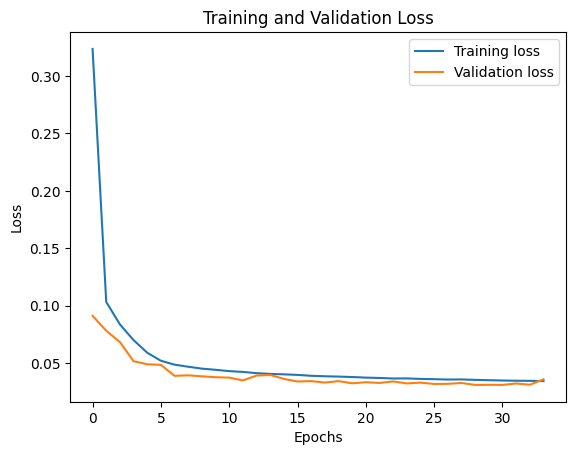

In [20]:
# Plot the training and validation metrics
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

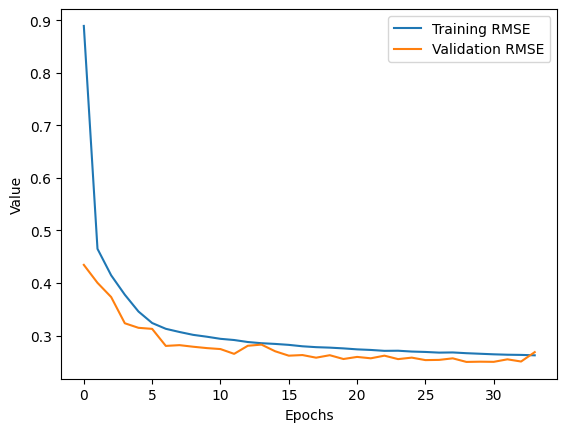

In [21]:
plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

In [22]:
# Evaluate the model on the test set
test_loss, test_rmse, test_cc = model.evaluate(X_test, y_test)

# Make predictions on the test set
y_pred = model.predict(X_test)

132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - cc: nan - loss: 0.0258 - root_mean_squared_error: 0.2226
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


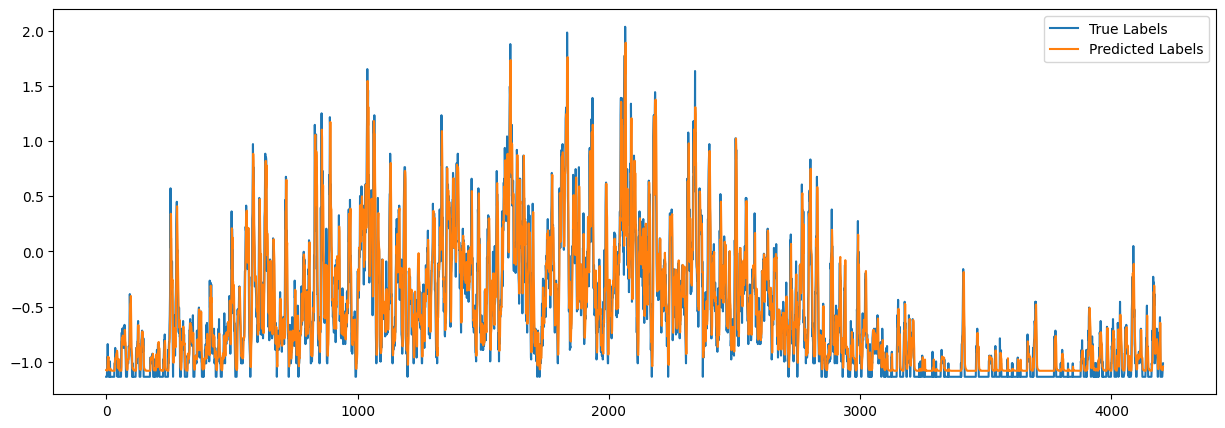

In [23]:
# Plot the predicted and true labels
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.plot(y_test, label='True Labels')
plt.plot(y_pred, label='Predicted Labels')
plt.legend()
plt.show()

In [24]:
#Step 9
#Evaluate the model on the 10, 100, 356 Days to Forecast
X_ten   = X_test[:10]
X_hundred = X_test[:100]
X_year = X_test[:365]

y_ten   = y_test[:10]
y_hundred = y_test[:100]
y_year = y_test[:365]

print("10 Day to Backcast")
test_loss, test_rmse, test_cc = model.evaluate(X_ten, y_ten)
y_pred_ten = model.predict(X_ten)


print("100 Days to Backcast")
test_loss, test_rmse, test_cc = model.evaluate(X_hundred, y_hundred)
y_pred_hundred = model.predict(X_hundred)

print("365 Days to Backcast")
test_loss, test_rmse, test_cc = model.evaluate(X_year, y_year)
y_pred_year = model.predict(X_year)

10 Day to Backcast
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - cc: 0.6240 - loss: 0.0027 - root_mean_squared_error: 0.0738
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
100 Days to Backcast
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - cc: 0.6269 - loss: 0.0041 - root_mean_squared_error: 0.0903 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
365 Days to Backcast
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - cc: 0.7091 - loss: 0.0063 - root_mean_squared_error: 0.1102
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [25]:
#Step 10
#Inverse from scaled data
inv_pred_ten = scaler.inverse_transform(y_pred_ten)
inv_ten      = scaler.inverse_transform(y_ten)

inv_pred_hundred = scaler.inverse_transform(y_pred_hundred)
inv_hundred      = scaler.inverse_transform(y_hundred)

inv_pred_year = scaler.inverse_transform(y_pred_year)
inv_year     = scaler.inverse_transform(y_year)

#Copy data date
viz_ten   = ten_day_date.copy()
viz_hundred = hundred_day_date.copy()
viz_year = one_year_date.copy()

#Join true and predicted data
viz_ten['sn_pred'] = inv_pred_ten
viz_ten['sn_true'] = inv_ten

viz_hundred['sn_pred'] = inv_pred_hundred
viz_hundred['sn_true'] = inv_hundred

viz_year['sn_pred'] = inv_pred_year
viz_year['sn_true'] = inv_year

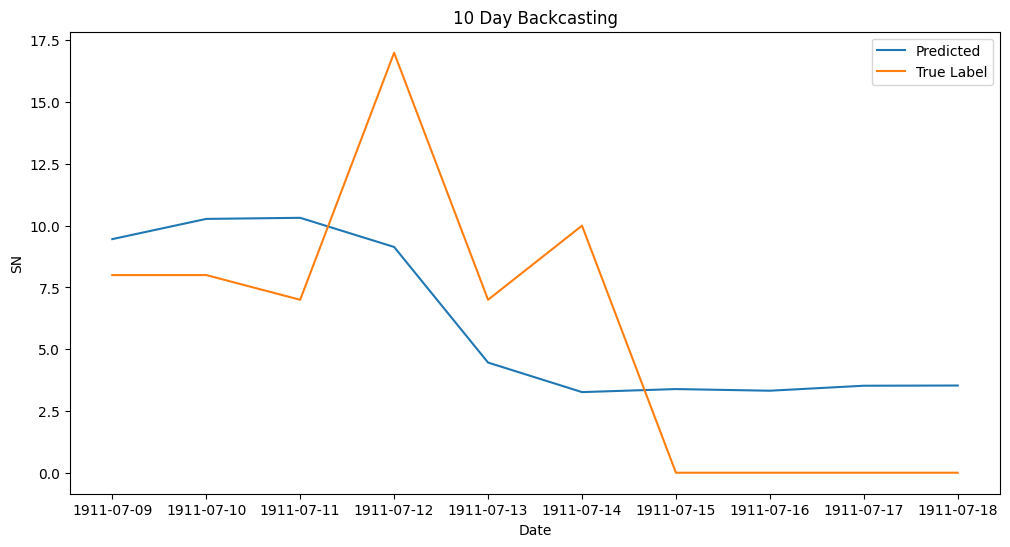

In [26]:
#10 Day Backcast

# Load dataset
viz_ten = viz_ten.set_index('Date')

# Plot two columns in one chart
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(viz_ten.index, viz_ten['sn_pred'], label='Predicted')
ax.plot(viz_ten.index, viz_ten['sn_true'], label='True Label')

# Add labels and legend
ax.set_xlabel('Date')
ax.set_ylabel('SN')
ax.set_title('10 Day Backcasting')
ax.legend()

# Show plot
plt.show()

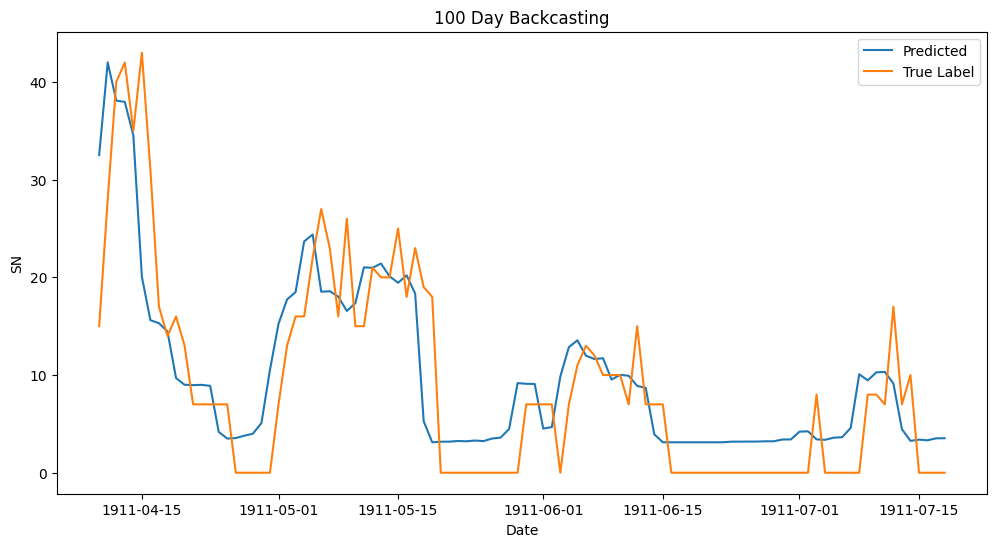

In [27]:
#100 Days Backcast

# Load dataset
viz_hundred = viz_hundred.set_index('Date')

# Plot two columns in one chart
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(viz_hundred.index, viz_hundred['sn_pred'], label='Predicted')
ax.plot(viz_hundred.index, viz_hundred['sn_true'], label='True Label')

# Add labels and legend
ax.set_xlabel('Date')
ax.set_ylabel('SN')
ax.set_title('100 Day Backcasting')
ax.legend()

# Show plot
plt.show()


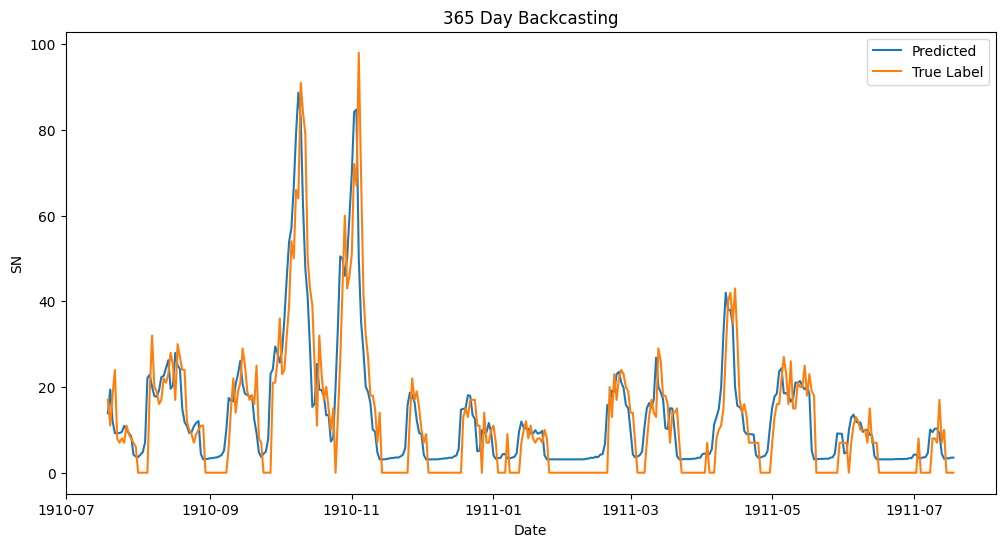

In [28]:
#365 Days Backcasting

# Load dataset
viz_year = viz_year.set_index('Date')

# Plot two columns in one chart
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(viz_year.index, viz_year['sn_pred'], label='Predicted')
ax.plot(viz_year.index, viz_year['sn_true'], label='True Label')

# Add labels and legend
ax.set_xlabel('Date')
ax.set_ylabel('SN')
ax.set_title('365 Day Backcasting')
ax.legend()

# Show plot
plt.show()




In [29]:
import pickle

# Save the trained model
model.save('/content/drive/MyDrive/Model/CNN-BiLSTM-Attention_Model_Backcast.h5')

# Save the history object
with open('/content/drive/MyDrive/Model/CNN-BiLSTM-Attention_history_Backcast.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [30]:
#Use Model To Forecasting
#Load Library, Model, and Addition First
#1. Merge array data for base predict
x_data = np.vstack((X_train, X_val, X_test))

In [31]:
#2. test model prediction
import numpy as np

# Set the window size and n_steps
n_steps = 100 # 100 days

# Get the last window_size data points
start_index = len(x_data) - n_steps
n_step = x_data[start_index:]

# Make the predictions
y_pred = model.predict(n_step)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [32]:
#3. Invers to original data
inv_data = scaler.inverse_transform(y_pred)

In [33]:
#4. Copy Dataframe
viz = df_sn.copy()

In [34]:
df_sn.tail()

,Date,Sn
4,1900-01-05,0
3,1900-01-04,0
2,1900-01-03,2
1,1900-01-02,7
0,1900-01-01,7


In [39]:
import pandas as pd

# Define the start date (100 days before 1900-01-01)
start_date = pd.to_datetime('1900-01-01') - pd.Timedelta(days=99)

# Create a date range from the start date up to 1900-01-01
date_range = pd.date_range(start=start_date, end='1900-01-01', freq='D')

# Print the date range
print(date_range)


DatetimeIndex(['1899-09-24', '1899-09-25', '1899-09-26', '1899-09-27',
               '1899-09-28', '1899-09-29', '1899-09-30', '1899-10-01',
               '1899-10-02', '1899-10-03', '1899-10-04', '1899-10-05',
               '1899-10-06', '1899-10-07', '1899-10-08', '1899-10-09',
               '1899-10-10', '1899-10-11', '1899-10-12', '1899-10-13',
               '1899-10-14', '1899-10-15', '1899-10-16', '1899-10-17',
               '1899-10-18', '1899-10-19', '1899-10-20', '1899-10-21',
               '1899-10-22', '1899-10-23', '1899-10-24', '1899-10-25',
               '1899-10-26', '1899-10-27', '1899-10-28', '1899-10-29',
               '1899-10-30', '1899-10-31', '1899-11-01', '1899-11-02',
               '1899-11-03', '1899-11-04', '1899-11-05', '1899-11-06',
               '1899-11-07', '1899-11-08', '1899-11-09', '1899-11-10',
               '1899-11-11', '1899-11-12', '1899-11-13', '1899-11-14',
               '1899-11-15', '1899-11-16', '1899-11-17', '1899-11-18',
      

In [40]:
#6. Merge Forecasting Date and Data
past = pd.DataFrame()
past["Date"] = date_range
past['Sn'] = inv_data
past

,Date,Sn
0,1899-09-24,9.531939
1,1899-09-25,9.099070
2,1899-09-26,9.252546
3,1899-09-27,9.789759
4,1899-09-28,10.580931
...,...,...
95,1899-12-28,3.598348
96,1899-12-29,3.516752
97,1899-12-30,3.393930
98,1899-12-31,3.453401


In [41]:
#7. Copy historical data for Visualization
history_predict = n_steps #Set by window_size, 100 days

hist_data = df_sn.copy()
hist_data

start_index = len(hist_data) - history_predict
hist_data = hist_data[start_index:]

In [42]:
#8. Set Index
hist_data = hist_data.set_index('Date')
past_data = past.set_index('Date')


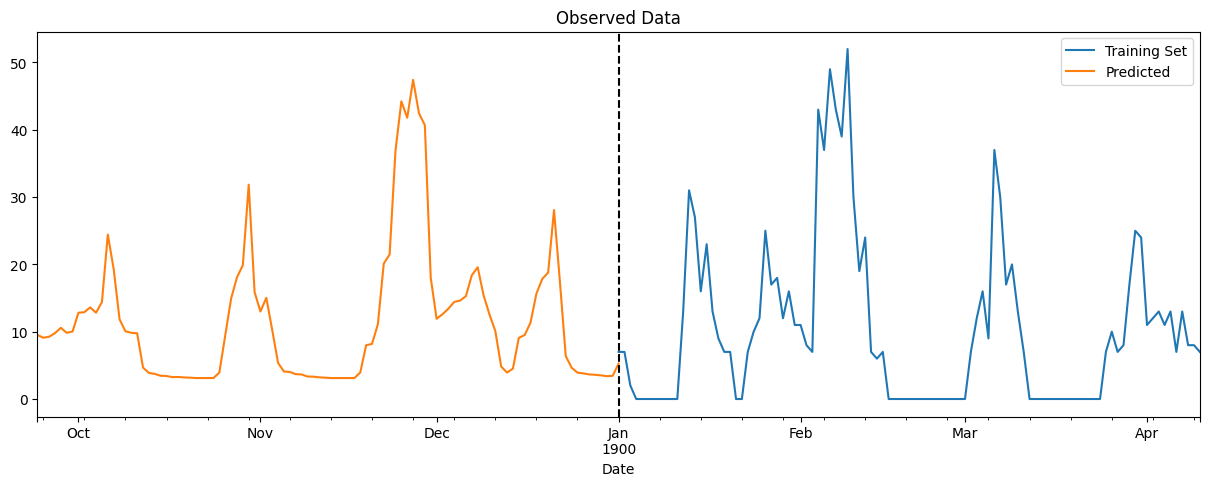

In [44]:
#9. Visualization

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 5))
hist_data.plot(ax=ax, label='Training Data', title='Observed Data')
past_data.plot(ax=ax, label='Predicted')
ax.axvline('1900-01-01', color='black', ls='--')
ax.legend(['Training Set', 'Predicted'])
plt.show()